# Calidad del Vino Tinto - Aprendizaje no supervisado

Este estudio utiliza el conjunto de datos Red Wine Quality, que contiene información físico-química y sensorial de vinos tintos producidos en la región del "Vinho Verde" en Portugal. Los datos fueron recolectados y publicados por Cortez et al. (2009) y están disponibles en el repositorio de aprendizaje automático de la UCI y en Kaggle.

El objetivo original del dataset fue modelar la calidad del vino en función de pruebas físico-químicas. Aunque fue diseñado para tareas de regresión o clasificación, en este trabajo se aborda desde una perspectiva de aprendizaje no supervisado, aplicando técnicas como PCA y K-means para explorar posibles agrupamientos naturales en los datos sin utilizar la variable de calidad como guía directa.



Variables: 

- fixed acidity – Acidez fija (g(tartaric acid)/dm³)
- volatile acidity – Acidez volátil (g(acetic acid)/dm³)
- citric acid – Ácido cítrico (g/dm³)
- residual sugar – Azúcar residual (g/dm³)
- chlorides – Cloruros (g(sodium chloride)/dm³)
- free sulfur dioxide – Dióxido de azufre libre (mg/dm³)
- total sulfur dioxide – Dióxido de azufre total (mg/dm³)
- density – Densidad del vino (g/cm³)
- pH – Nivel de pH
- sulphates – Sulfatos (g(potassium sulphate)/dm³)
- alcohol – Contenido de alcohol (% vol.)
- quality – Puntuación de calidad del vino (valor entero entre 0 y 10 según evaluación sensorial)

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, silhouette_score
import warnings
import optuna
warnings.filterwarnings('ignore')

## EDA

In [3]:
# Cargar dataset
df = pd.read_csv("winequality-red.csv")

# Primeras filas
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
# Tipos de datos y valores nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


#### Estadísticas descriptivas

In [5]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


El análisis exploratorio revela que el dataset es numérico, completo y adecuado para aplicar técnicas de aprendizaje no supervisado como PCA y K-means. Algunas variables, como residual sugar y total sulfur dioxide, presentan valores extremos y distribuciones asimétricas, lo que sugiere la necesidad de estandarización para evitar que dominen el análisis. Otras, como alcohol y pH, muestran variabilidad moderada, lo que podría contribuir a diferenciar observaciones. La variable quality, aunque no será utilizada como objetivo, está sesgada hacia valores medios (5-6), y servirá como referencia al evaluar la coherencia de los grupos descubiertos. En conjunto, los datos muestran estructura suficiente para extraer patrones mediante técnicas no supervisadas.

### Distribuciones de las variables numéricas

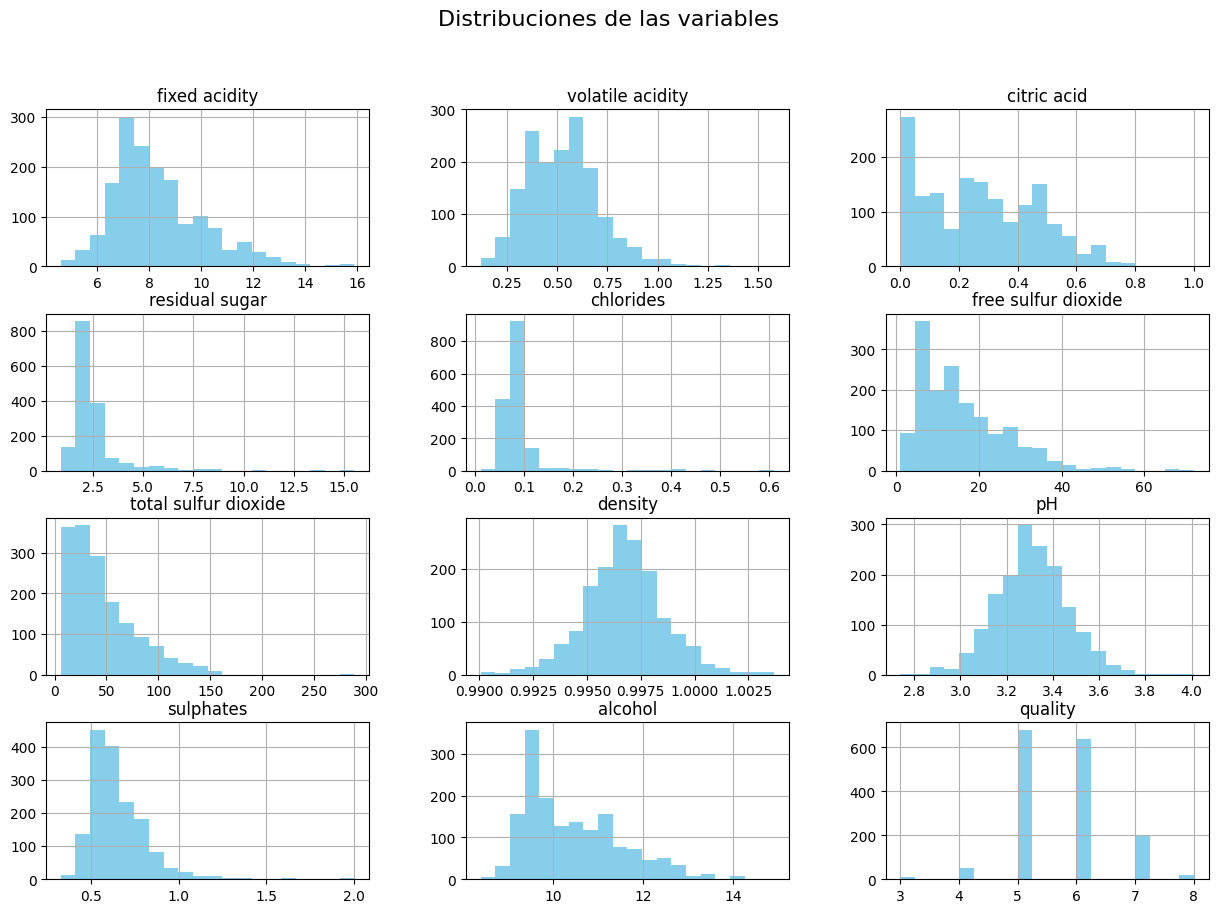

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

df.hist(bins=20, figsize=(15, 10), color='skyblue')
plt.suptitle("Distribuciones de las variables", fontsize=16)
plt.show()

El análisis de las distribuciones revela que la mayoría de las variables químicas del vino tinto no siguen una distribución normal. Variables como residual sugar, chlorides, free sulfur dioxide y total sulfur dioxide presentan una fuerte asimetría positiva (sesgo a la derecha), lo que indica la presencia de valores extremos más altos que el promedio. Esto puede ser relevante en la producción de vinos, ya que niveles elevados de azúcar residual o dióxido de azufre podrían impactar tanto en el sabor como en la estabilidad del vino.

Por otro lado, variables como fixed acidity y volatile acidity tienden a seguir una distribución más simétrica, aunque también muestran cierta variabilidad. El pH y el alcohol presentan distribuciones aproximadamente normales, especialmente esta última, lo que podría facilitar su uso en modelos estadísticos o de aprendizaje automático. Finalmente, la variable quality muestra una distribución discreta, con la mayoría de observaciones concentradas en los niveles 5 y 6, lo cual indica que las evaluaciones de calidad están centradas en valores medios, con pocos vinos considerados de muy baja o muy alta calidad.

### Correlaciones entre variables

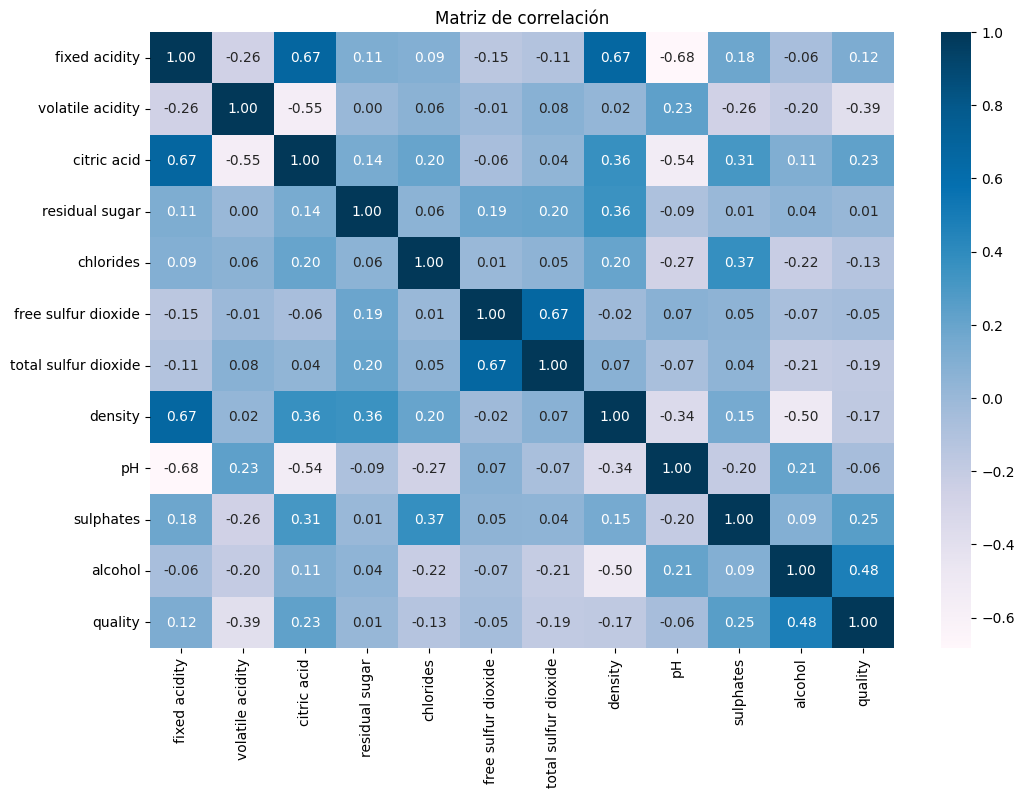

In [9]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='PuBu', fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

La matriz de correlación permite identificar relaciones lineales entre variables. Una de las observaciones más relevantes es la correlación positiva entre alcohol y quality (r = 0.48), lo que sugiere que, en promedio, los vinos con mayor contenido alcohólico tienden a recibir mejores puntuaciones de calidad. Esto puede estar relacionado con la percepción de cuerpo o intensidad del vino, atributos apreciados por los catadores.

Por el contrario, la volatile acidity muestra una correlación negativa con la calidad (r = -0.39), lo que indica que niveles más altos de acidez volátil, generalmente asociados a defectos sensoriales, tienden a disminuir la evaluación del vino. También es destacable la fuerte correlación positiva entre free sulfur dioxide y total sulfur dioxide (r = 0.67), ya que ambos son conservantes relacionados, y entre fixed acidity y density (r = 0.67), lo cual es lógico dado que la acidez contribuye al peso del vino.

En términos generales, la matriz muestra que, aunque existen algunas asociaciones fuertes entre variables, muchas otras tienen correlaciones débiles, lo que indica que contienen información diferenciada y no redundante, útil para técnicas multivariadas como PCA.

## PCA (Con estandarización)

In [12]:
# Seleccionar variables numéricas relevantes
X = df.drop(columns=["quality"])  # dejamos solo variables de entrada

# Estandarizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

## Scree Plot

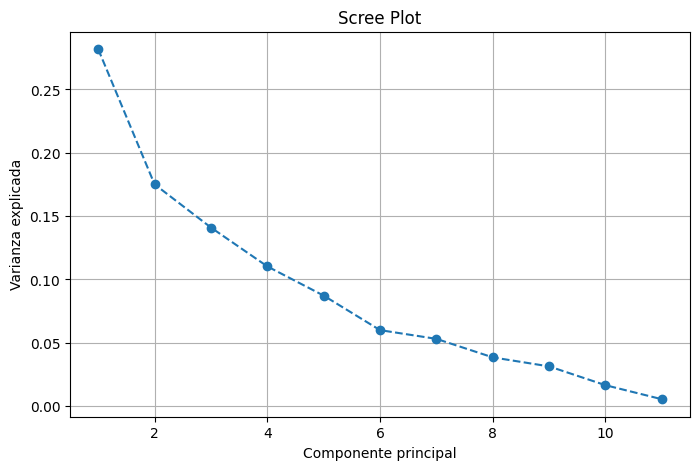

In [13]:
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Componente principal')
plt.ylabel('Varianza explicada')
plt.grid()
plt.show()

El scree plot del PCA muestra cómo se distribuye la varianza explicada entre los diferentes componentes principales. Los dos primeros componentes capturan aproximadamente el 45% de la varianza total del conjunto de datos, lo cual justifica su uso para una representación bidimensional sin perder demasiada información. A partir del tercer componente, la ganancia en varianza explicada comienza a disminuir considerablemente, lo que sugiere que los componentes posteriores aportan información menos significativa y más dispersa.

## Reducción a 2 componentes

In [14]:
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled)

## Diagrama de dispersión

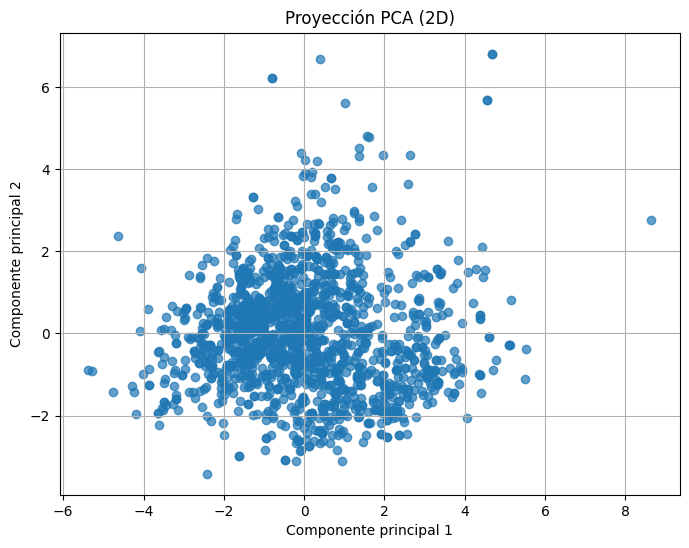

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], alpha=0.7)
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('Proyección PCA (2D)')
plt.grid()
plt.show()


La proyección en 2D del PCA muestra una nube de puntos relativamente compacta y sin agrupaciones visibles o clústeres bien definidos. Esto indica que los datos no presentan una estructura natural de grupos claramente separables en los primeros dos componentes, aunque sí reflejan una dispersión que puede responder a la variabilidad combinada de variables como alcohol, acidez y sulfuros. La visualización también confirma que, aunque la reducción a dos dimensiones ayuda a simplificar el análisis, se pierde parte de la complejidad del espacio original, lo cual es importante considerar si se aplicarán técnicas de segmentación como K-means posteriormente.

## Técnica de selección de variables

Usando la importancia con árbol de decisión

In [18]:
# Usando la variable 'quality' como referencia
y = df['quality']
clf = DecisionTreeClassifier()
clf.fit(X, y)

# Selección de características
model = SelectFromModel(clf, prefit=True)
X_selected = model.transform(X)

Importancia de características con árbol de decisión:
Se entrenó un clasificador de árbol de decisión usando la variable quality como objetivo. Las variables con importancia baja (menor al umbral definido por el modelo) fueron eliminadas. Este enfoque permite identificar qué atributos contribuyen más a predecir la calidad del vino, priorizando las variables más informativas.

## Algoritmo K-means

In [20]:

def evaluar_kmeans(X, k_range=range(2, 7)):
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        print(f"K={k}, Silhouette Score={score:.3f}")

print("Original:")
evaluar_kmeans(X_scaled)

print("\nPCA 2D:")
evaluar_kmeans(X_pca_2)

print("\nReducción de características:")
X_sel_scaled = scaler.fit_transform(X_selected)
evaluar_kmeans(X_sel_scaled)

Original:
K=2, Silhouette Score=0.214
K=3, Silhouette Score=0.189
K=4, Silhouette Score=0.185
K=5, Silhouette Score=0.165
K=6, Silhouette Score=0.181

PCA 2D:
K=2, Silhouette Score=0.399
K=3, Silhouette Score=0.378
K=4, Silhouette Score=0.368
K=5, Silhouette Score=0.334
K=6, Silhouette Score=0.335

Reducción de características:
K=2, Silhouette Score=0.255
K=3, Silhouette Score=0.247
K=4, Silhouette Score=0.258
K=5, Silhouette Score=0.236
K=6, Silhouette Score=0.232


### Interpretación: 

Los resultados del clustering usando K-means muestran diferencias significativas según la transformación aplicada a los datos. Al aplicar el algoritmo sobre las variables originales, se observa un bajo desempeño general, siendo el mejor resultado con K=2 y un Silhouette Score de 0.214. Este valor indica una separación débil entre grupos, posiblemente debido a la alta dimensionalidad o a la escala desigual entre variables. En contraste, al reducir los datos a dos componentes principales mediante PCA, los resultados mejoran notablemente. El valor más alto se obtiene con K=2 y un Silhouette Score de 0.399, seguido de puntajes razonables con K=3 y K=4, lo que sugiere una mejor estructura de agrupamiento en el espacio reducido. Por otro lado, al aplicar una selección de características, se logra un rendimiento intermedio, con el mayor puntaje en K=4 (0.258), lo que indica una leve mejora respecto a los datos originales, aunque no alcanza los niveles logrados con PCA. 

En general, los resultados sugieren que la reducción de dimensionalidad mediante PCA no solo facilita la visualización de los datos, sino que también mejora significativamente la calidad del agrupamiento.